# Snow cover extent monthly bias
For checking the reliability of the fig1/2 (above all over HK)

In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
plot.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

import sys
sys.path.insert(1, '/home/mlalande/notebooks/utils') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
# u.check_virtual_memory()

3.8.5 | packaged by conda-forge | (default, Jul 24 2020, 01:25:15) 
[GCC 7.5.0]


## Set variables

In [3]:
period = slice('1979','2014')
latlim, lonlim = u.get_domain_HMA()
seasons = ['Annual', 'DJFMA', 'JJAS']
# seasons = ['Annual']

# Make a extended version for regridding properly on the edges
latlim_ext, lonlim_ext = slice(latlim.start-5, latlim.stop+5), slice(lonlim.start-5, lonlim.stop+5)

# Get zone limits for annual cycle
lonlim_HK, latlim_HK, lonlim_HM, latlim_HM, lonlim_TP, latlim_TP = u.get_zones()

# HMA for full domain and the following for the above zones
zones = ['HMA', 'HK', 'HM', 'TP']
zones_df = pd.DataFrame(
    [[lonlim, latlim], [lonlim_HK, latlim_HK], [lonlim_HM, latlim_HM], [lonlim_TP, latlim_TP]], 
    columns=pd.Index(['lonlim', 'latlim'], name='Limits'),
    index=pd.Index(zones, name='Zones')
)

var = 'snc'
table = u.get_table(var)
label, units, levels, cmap, extend, \
    levels_diff, cmap_diff, extend_diff, \
    levels_bias, cmap_bias, extend_bias = u.get_var_infos(var)
label

'Snow Cover Extent'

## Load topography

In [4]:
ds = xr.open_dataset('GMTED2010_15n240_1000deg.nc').drop_dims('nbounds').swap_dims(
    {'nlat': 'latitude', 'nlon': 'longitude'}).drop({'nlat', 'nlon'}).rename(
    {'latitude': 'lat', 'longitude': 'lon'}).sel(lat=latlim_ext, lon=lonlim_ext)
elevation = ds.elevation
elevation_std = ds.elevation_stddev

## Load obs
NOAA Climate Data Record (CDR) of Northern Hemisphere (NH) Snow Cover Extent (SCE), Version 1:
https://data.nodc.noaa.gov/cgi-bin/iso?id=gov.noaa.ncdc:C00756

In [5]:
obs_longname = 'NOAA Climate Data Record (CDR) Version 1'
obs_name = 'NOAA CDR'

ds_rutger = xr.open_dataset('/data/mlalande/RUTGERS/nhsce_v01r01_19661004_20191202.nc').sel(time=period)
with xr.set_options(keep_attrs=True): # Get the snc variable, keep only land data and convert to %
    obs = ds_rutger.snow_cover_extent.where(ds_rutger.land == 1)*100   
obs.attrs['units'] = '%'
obs = obs.rename({'longitude': 'lon', 'latitude': 'lat'}) # Rename lon and lat for the regrid

# Resamble data per month (from per week)
obs = obs.resample(time='1MS').mean('time', skipna=False, keep_attrs=True)

# Check if the time steps are ok
np.testing.assert_equal((int(period.stop) - int(period.start) + 1)*12, obs.time.size)

/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


## Regrid obs towards the elevation grid of 1°x1°
Using xESMF (https://xesmf.readthedocs.io/en/latest/)

In [9]:
# Because obs are not global (https://github.com/JiaweiZhuang/xESMF/issues/15)
import scipy
def add_matrix_NaNs(regridder):
        X = regridder.weights
        M = scipy.sparse.csr_matrix(X)
        num_nonzeros = np.diff(M.indptr)
        M[num_nonzeros == 0, 0] = np.NaN
        regridder.weights = scipy.sparse.coo_matrix(M)
        return regridder

regridder = xe.Regridder(obs, elevation, 'bilinear', periodic=False, reuse_weights=True)
regridder = add_matrix_NaNs(regridder)
obs_regrid = regridder(obs)
obs_regrid.attrs['long_name'] = label
obs_regrid.attrs['units'] = units

Reuse existing file: bilinear_88x88_35x60.nc


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [32]:
obs_monthly_clim = obs_regrid.groupby('time.month').mean('time')
obs_monthly_clim.load()

/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


<xarray.DataArray 'snow_cover_extent' (month: 12, lat: 35, lon: 60)>
array([[[         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        ...,
        [ 93.56648105,  94.81970435,  94.17983929, ...,  99.43471265,
          99.4069272 ,  99.33497403],
        [ 96.41402434,  97.94807587,  98.79147682, ...,  99.59371961,
          99.60909858,  99.42559331],
        [ 98.04941603,  98.93350158,  99.76939798, ...,  99.98415181,
         100.        ,  99.74183154]],

       [[         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
...
        [ 14.38938291,  15.62184043,  17.02705043, ...,  48.3656527 ,
          46.39446118,  43.12352582],
        [ 22.51748959,  24.26162278,  26.60585034, ...,  52.61412896,
          50.44846578,  48.41211779],
        [ 32.55264377,  34.82807775,  37.12530901, ...,  57.64939028,
          55.20157229,  54.12422266]],

       [[         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        ...,
        [ 62.36485844,  66.49731975,  69.48100505, ...,  89.5248061 ,
          90.90607424,  91.99411325],
        [ 75.55329889,  78.44925053,  81.71036881, ...,  89.09007669,
          89.70767732,  92.04092494],
        [ 85.71218074,  87.78362728,  90.85804034, ...,  89.29823507,
          88.77193995,  91.32657765]]])
Coordinates:
    snow_cover_threshold  float32 0.42
  * lon                   (lon) float32 55.5 56.5 57.5 ... 112.5 113.5 114.5
  * lat                   (lat) float32 15.5 16.5 17.5 18.5 ... 47.5 48.5 49.5
  * month                 (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

## Load models

In [24]:
list_models = u.get_model_names()
# list_models = list_models[:2]
# list_models = ['MPI-ESM-1-2-HAM']

montlhy_clim = [None] * (len(list_models))

for i, model in enumerate(list_models):
    print(model + ' ('+str(i+1)+'/'+str(len(list_models))+')')
    institute, grid, realization, calendar = u.get_model_infos(model, var)
    ds = xr.open_mfdataset(
        '/bdd/CMIP6/CMIP/'+institute+'/'+model+'/historical/'+realization+'/'+table+'/'+var+'/'+grid+'/latest/*.nc', 
        combine='by_coords').sel(time=period, lat=latlim_ext, lon=lonlim_ext)[var]
    
    # Check if the time steps are ok
    np.testing.assert_equal((int(period.stop) - int(period.start) + 1)*12, ds.time.size)
    
    # snc (0-1 to % when needed and take out wrong values)
    #################################################################################
    
    # Some models have values between 0 and 1 even if units in %    
    if ds.max().values <= 1.1:
        ds = ds*100
    ds
    
    # Some models have wrong values (+-0.1 for numeric precision)
    ds = ds.where( (ds >= -0.1) & (ds <= 100.1) )
    
    #################################################################################
    
    # Print resolution and save it
    lat = (ds.lat[1] - ds.lat[0]).values; lon = (ds.lon[1] - ds.lon[0]).values
    print(str(lon.round(3))+'°x'+str(lat.round(3))+'°')
    
    # Make regridder
    regridder = xe.Regridder(ds, elevation, 'bilinear', periodic=False, reuse_weights=True)
    ds_regrid = regridder(ds)
    
    # Compute annual cycle for all HMA domain (>2500m) + zones
    montlhy_clim[i] = ds_regrid.groupby('time.month').mean('time')
        
    print('\n')

BCC-CSM2-MR (1/26)
1.125°x1.121°
Reuse existing file: bilinear_32x54_35x60.nc


BCC-ESM1 (2/26)
2.812°x2.791°
Reuse existing file: bilinear_13x21_35x60.nc


CAS-ESM2-0 (3/26)
1.406°x1.417°
Reuse existing file: bilinear_24x42_35x60.nc


CESM2 (4/26)


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/conventions.py:490: SerializationWarning: variable 'snc' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


1.25°x0.942°
Reuse existing file: bilinear_37x49_35x60.nc


CESM2-FV2 (5/26)


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/conventions.py:490: SerializationWarning: variable 'snc' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


2.5°x1.895°
Reuse existing file: bilinear_18x25_35x60.nc


CESM2-WACCM (6/26)


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/conventions.py:490: SerializationWarning: variable 'snc' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


1.25°x0.942°
Reuse existing file: bilinear_37x49_35x60.nc


CESM2-WACCM-FV2 (7/26)


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/conventions.py:490: SerializationWarning: variable 'snc' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


2.5°x1.895°
Reuse existing file: bilinear_18x25_35x60.nc


CNRM-CM6-1 (8/26)
1.406°x1.401°
Reuse existing file: bilinear_25x42_35x60.nc


CNRM-CM6-1-HR (9/26)
0.5°x0.499°
Reuse existing file: bilinear_70x121_35x60.nc


CNRM-ESM2-1 (10/26)
1.406°x1.401°
Reuse existing file: bilinear_25x42_35x60.nc


CanESM5 (11/26)
2.812°x2.791°
Reuse existing file: bilinear_13x21_35x60.nc


GFDL-CM4 (12/26)
1.25°x1.0°
Reuse existing file: bilinear_35x48_35x60.nc


GISS-E2-1-G (13/26)
2.5°x2.0°
Reuse existing file: bilinear_18x24_35x60.nc


GISS-E2-1-H (14/26)
2.5°x2.0°
Reuse existing file: bilinear_18x24_35x60.nc


HadGEM3-GC31-LL (15/26)
1.875°x1.25°
Reuse existing file: bilinear_28x32_35x60.nc


HadGEM3-GC31-MM (16/26)
0.833°x0.556°
Reuse existing file: bilinear_63x72_35x60.nc


IPSL-CM6A-LR (17/26)
2.5°x1.268°
Reuse existing file: bilinear_28x25_35x60.nc


MIROC-ES2L (18/26)
2.812°x2.791°
Reuse existing file: bilinear_13x21_35x60.nc


MIROC6 (19/26)
1.406°x1.401°
Reuse existing file: bilinear_25x42_

In [26]:
multimodel_monthly_clim = xr.concat(montlhy_clim, pd.Index(list_models, name="model"))
multimodel_monthly_clim

,Array,Chunk
Bytes,5.24 MB,16.80 kB
Shape,"(26, 12, 35, 60)","(1, 1, 35, 60)"
Count,3179 Tasks,312 Chunks
Type,float64,numpy.ndarray


In [31]:
multimodel_mean_monthly_clim = multimodel_monthly_clim.mean('model')
multimodel_mean_monthly_clim.load()

/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<xarray.DataArray 'snc' (month: 12, lat: 35, lon: 60)>
array([[[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [39.47616719, 72.35036666, 75.17720596, ..., 77.56759011,
         61.88426929, 35.71869337],
        [37.63401105, 74.2444667 , 76.07092527, ..., 70.93069485,
         54.85259746, 28.13471566],
        [14.35238977, 29.20328588, 29.52997988, ..., 26.56346156,
         26.57684185, 13.01109465]],

       [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
...
        [ 7.82250208, 13.0775999 , 14.1598303 , ..., 43.19665485,
         30.72430424, 15.68876008],
        [10.64890663, 18.28804918, 19.29523109, ..., 45.1611209 ,
         31.04034373, 14.71736577],
        [ 5.39430454,  8.30224441,  8.78567443, ..., 20.51210055,
         19.34724264,  8.545128  ]],

       [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [24.60814164, 44.64239841, 47.14045908, ..., 67.37142626,
         52.6810026 , 29.43085504],
        [26.49658216, 51.68145793, 54.33533362, ..., 63.6704956 ,
         48.14542311, 24.19973088],
        [11.43973424, 22.69578897, 23.68499798, ..., 25.11138279,
         24.62618968, 11.7708056 ]]])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * lat      (lat) float32 15.5 16.5 17.5 18.5 19.5 ... 45.5 46.5 47.5 48.5 49.5
  * lon      (lon) float32 55.5 56.5 57.5 58.5 59.5 ... 111.5 112.5 113.5 114.5

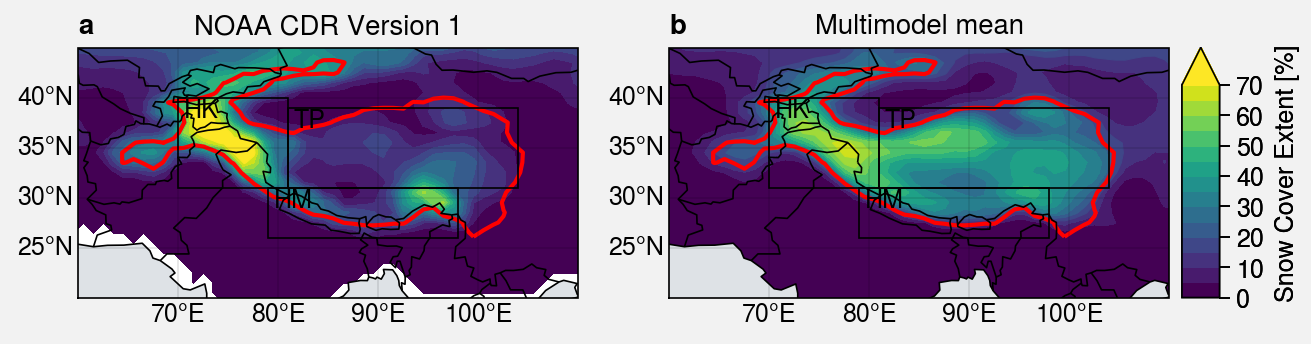

In [33]:
f, axs = plot.subplots(proj='cyl', ncols=2, nrows=1)

# tas, snc, pr
cmap_list = ['viridis']
levels_list = [plot.arange(0,70,5)]
extend_list = ['max']
norm_list = [None]

k = 0
for i, var in enumerate(['snc']):
    
    label, units, levels, cmap, extend, \
        levels_diff, cmap_diff, extend_diff, \
        levels_bias, cmap_bias, extend_bias = u.get_var_infos(var)
    
    # Obs
    axs[k].contourf(obs_monthly_clim.mean('month'), cmap=cmap_list[i], levels=levels_list[i], extend=extend_list[i], norm=norm_list[i])
    k += 1
    
    # Model
    m = axs[k].contourf(multimodel_mean_monthly_clim.mean('month'), cmap=cmap_list[i], levels=levels_list[i], extend=extend_list[i], norm=norm_list[i])
    axs[k].colorbar(m, label=label+' ['+units+']')
    k += 1


# Plot zones
for ax in axs:
    u.plot_zones(ax)
    ax.contour(elevation, levels=[2500], color='red')
    ax.format(title='')

# Format
axs.format(
    # Grids, labels and limits
    labels=True, lonlines=10, latlines=5, 
    latlim=(latlim.start, latlim.stop), lonlim=(lonlim.start, lonlim.stop),
    coast=True, ocean=True, oceancolor='gray3', borders=True,
    abc=True,
)

for ax, title in zip(axs, [
    'NOAA CDR Version 1', 'Multimodel mean',
]):
    ax.format(title=title)


# Save
filename = 'fig1_topo-cllim_'+period.start+'-'+period.stop
# f.save('img/'+filename+'.jpg'); f.save('img/'+filename+'.png'); f.save('img/'+filename+'.pdf')

In [34]:
obs_monthly_clim.month

<xarray.DataArray 'month' (month: 12)>
array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])
Coordinates:
    snow_cover_threshold  float32 0.42
  * month                 (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [35]:
import calendar

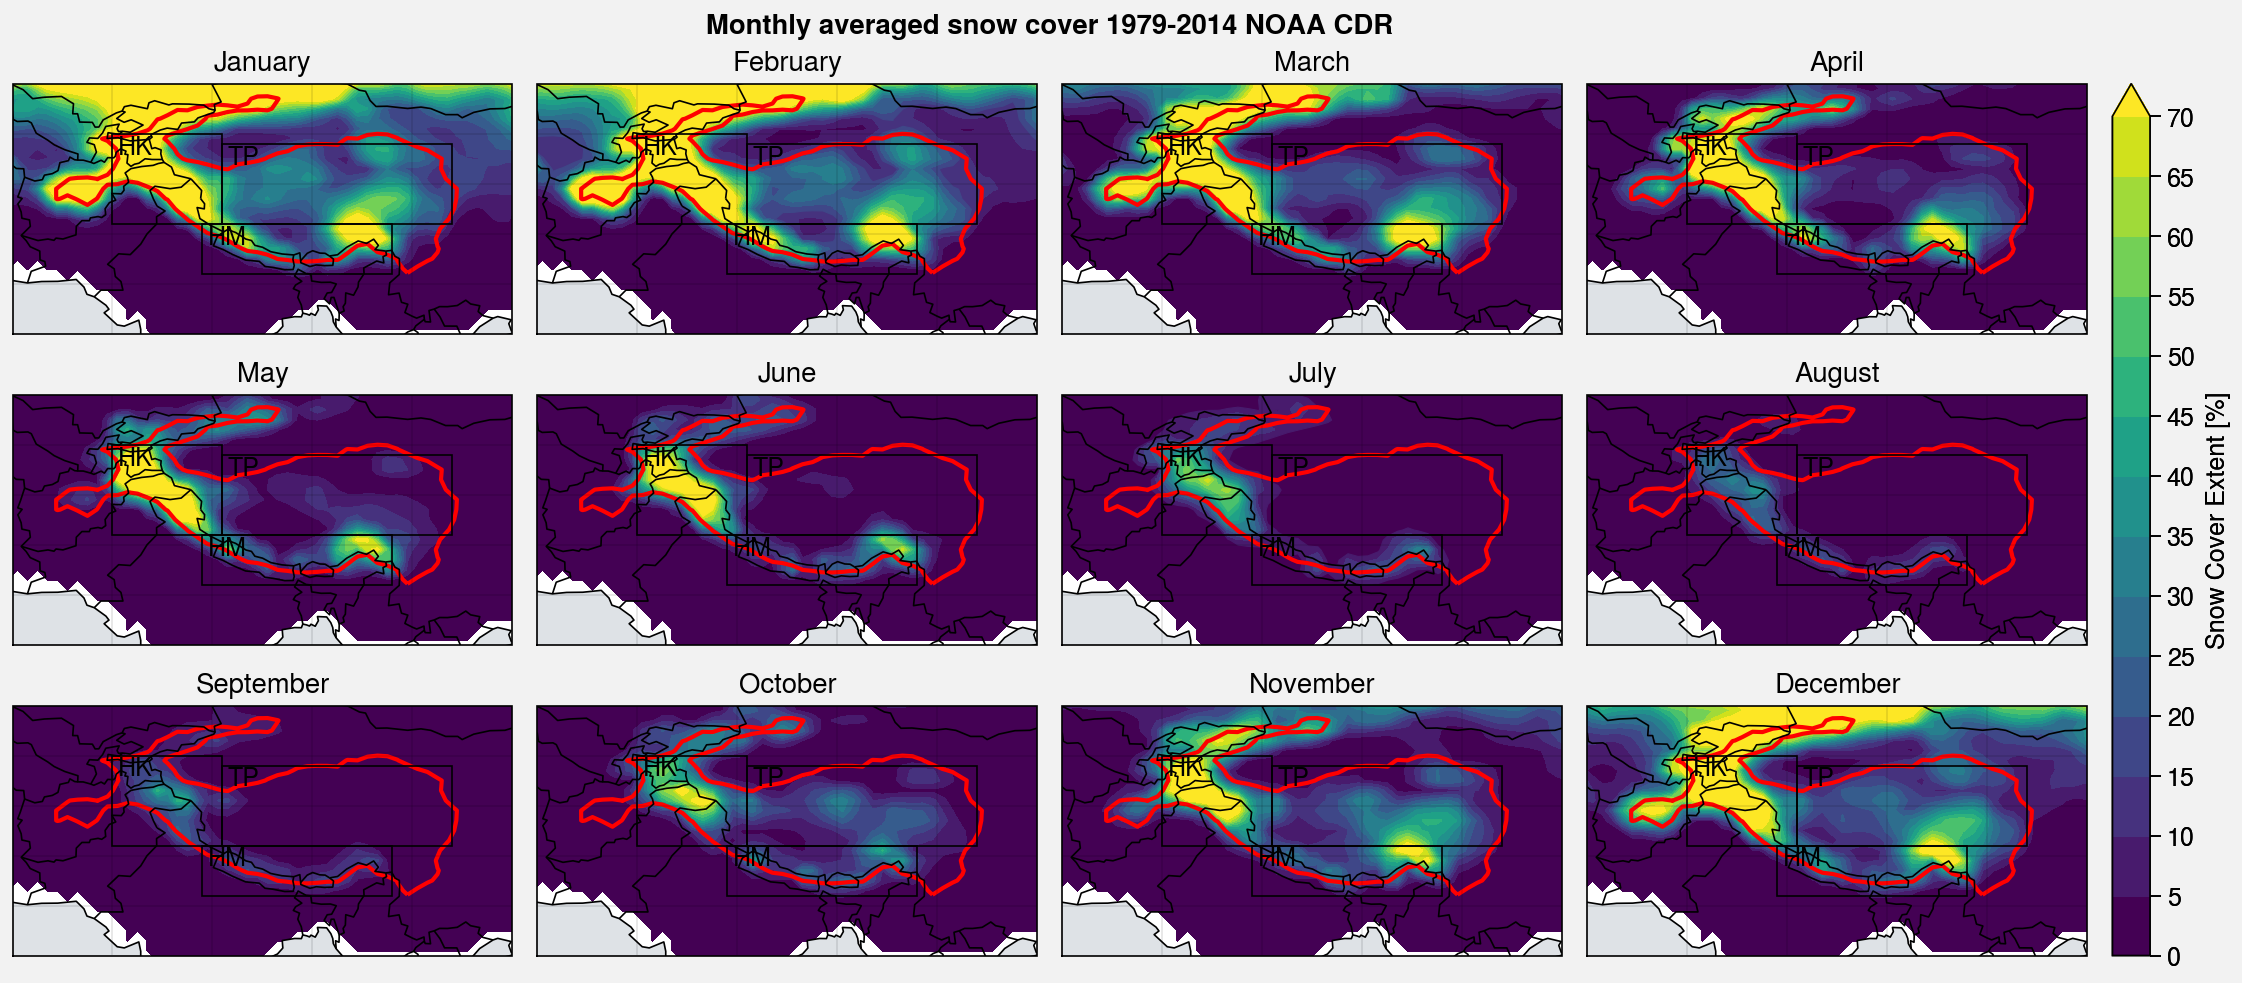

In [46]:
f, axs = plot.subplots(proj='cyl', ncols=4, nrows=3)

# tas, snc, pr
cmap = 'viridis'
levels = plot.arange(0,70,5)
extend = 'max'
norm = None

for i, month in enumerate(obs_monthly_clim.month.values):
    
    # Obs
    m = axs[i].contourf(obs_monthly_clim.isel(month=i), cmap=cmap, levels=levels, extend=extend, norm=norm)
    axs[i].format(title=calendar.month_name[i+1])


# Plot zones
for ax in axs:
    u.plot_zones(ax)
    ax.contour(elevation, levels=[2500], color='red')

# Format
axs.format(
    # Grids, labels and limits
    labels=False, lonlines=10, latlines=5, 
    latlim=(latlim.start, latlim.stop), lonlim=(lonlim.start, lonlim.stop),
    coast=True, ocean=True, oceancolor='gray3', borders=True,
    abc=False,
    suptitle='Monthly averaged snow cover 1979-2014 NOAA CDR'
)

    
f.colorbar(m, label=label+' ['+units+']')

# Save
filename = 'fig1_topo-cllim_'+period.start+'-'+period.stop
# f.save('img/'+filename+'.jpg'); f.save('img/'+filename+'.png'); f.save('img/'+filename+'.pdf')

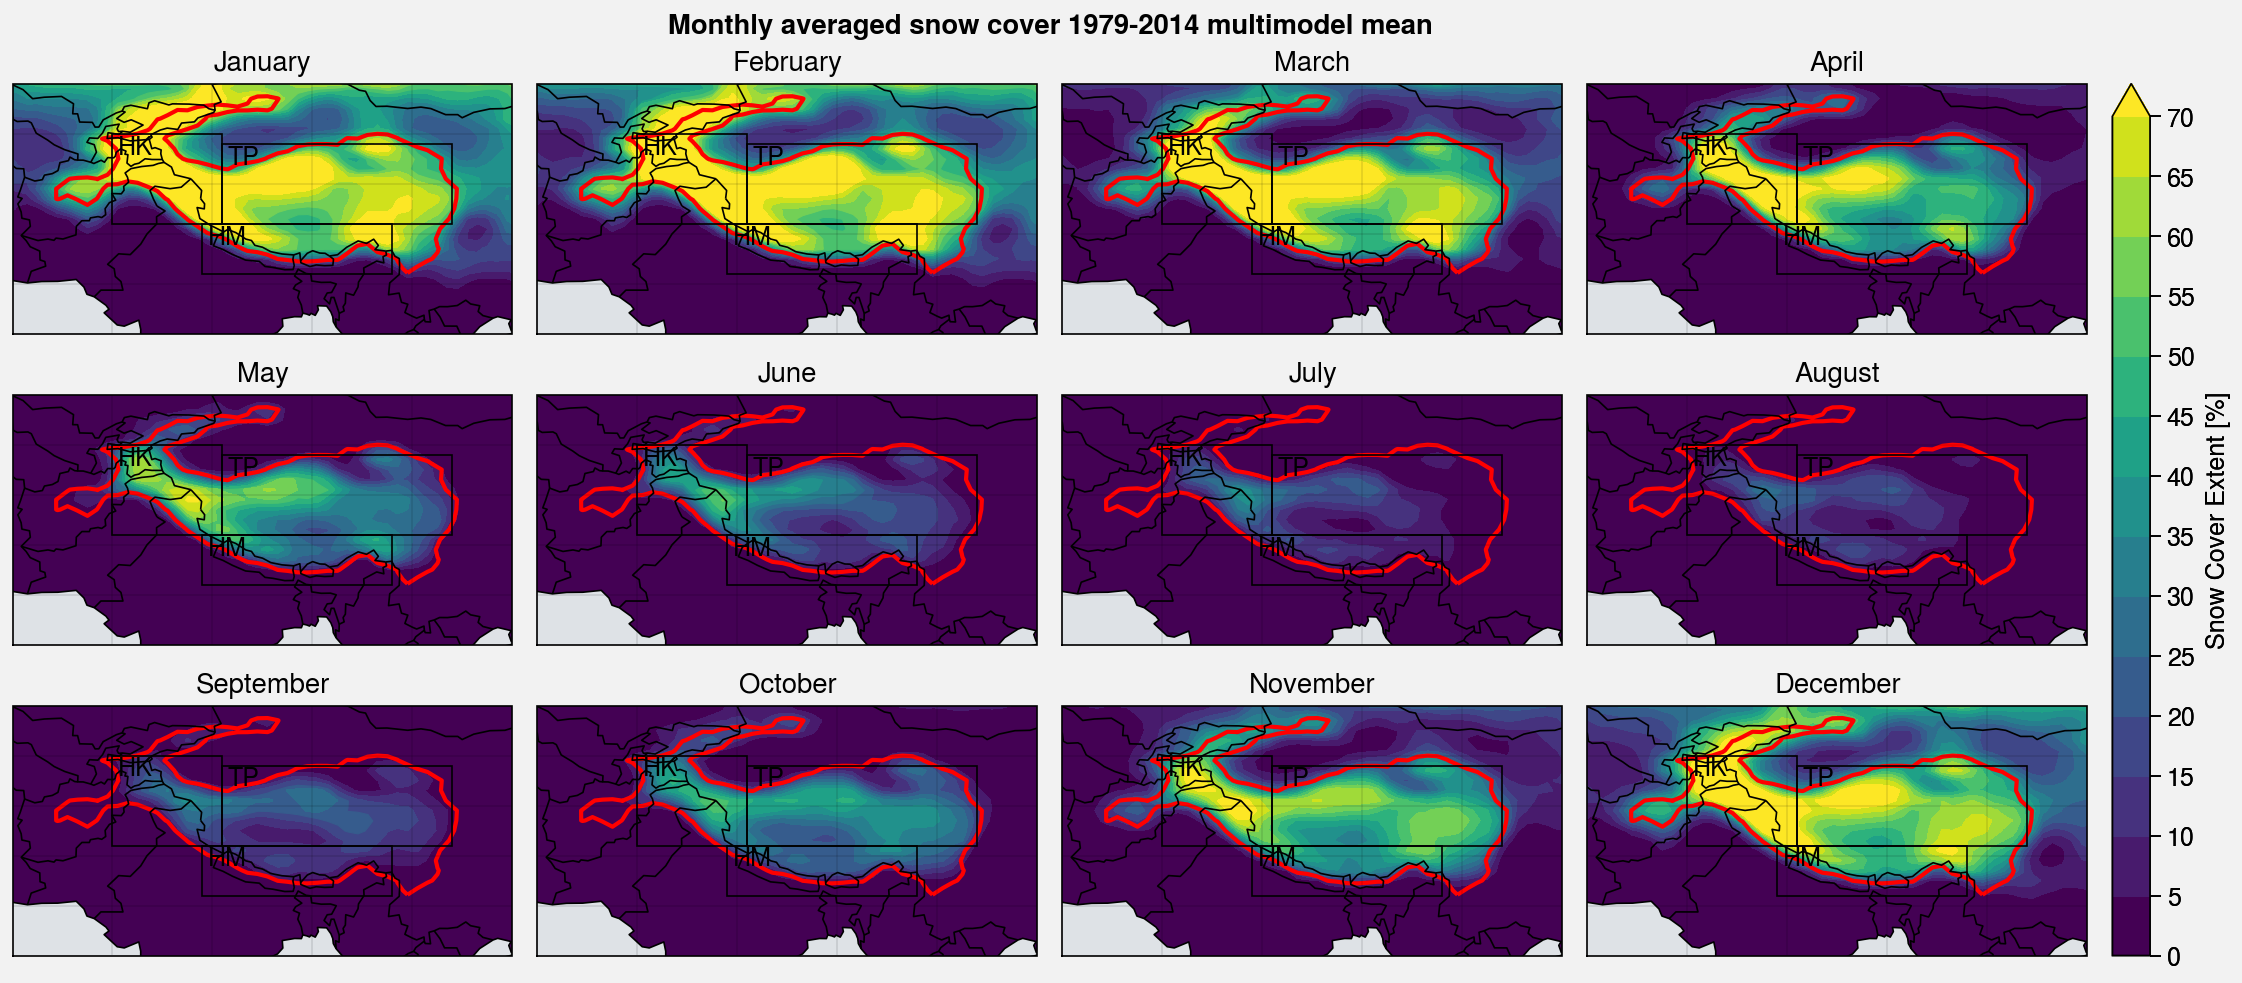

In [47]:
f, axs = plot.subplots(proj='cyl', ncols=4, nrows=3)

# tas, snc, pr
cmap = 'viridis'
levels = plot.arange(0,70,5)
extend = 'max'
norm = None

for i, month in enumerate(obs_monthly_clim.month.values):
    
    # Obs
    m = axs[i].contourf(multimodel_mean_monthly_clim.isel(month=i), cmap=cmap, levels=levels, extend=extend, norm=norm)
    axs[i].format(title=calendar.month_name[i+1])


# Plot zones
for ax in axs:
    u.plot_zones(ax)
    ax.contour(elevation, levels=[2500], color='red')

# Format
axs.format(
    # Grids, labels and limits
    labels=False, lonlines=10, latlines=5, 
    latlim=(latlim.start, latlim.stop), lonlim=(lonlim.start, lonlim.stop),
    coast=True, ocean=True, oceancolor='gray3', borders=True,
    abc=False,
    suptitle='Monthly averaged snow cover 1979-2014 multimodel mean'
)

    
f.colorbar(m, label=label+' ['+units+']')

# Save
filename = 'fig1_topo-cllim_'+period.start+'-'+period.stop
# f.save('img/'+filename+'.jpg'); f.save('img/'+filename+'.png'); f.save('img/'+filename+'.pdf')

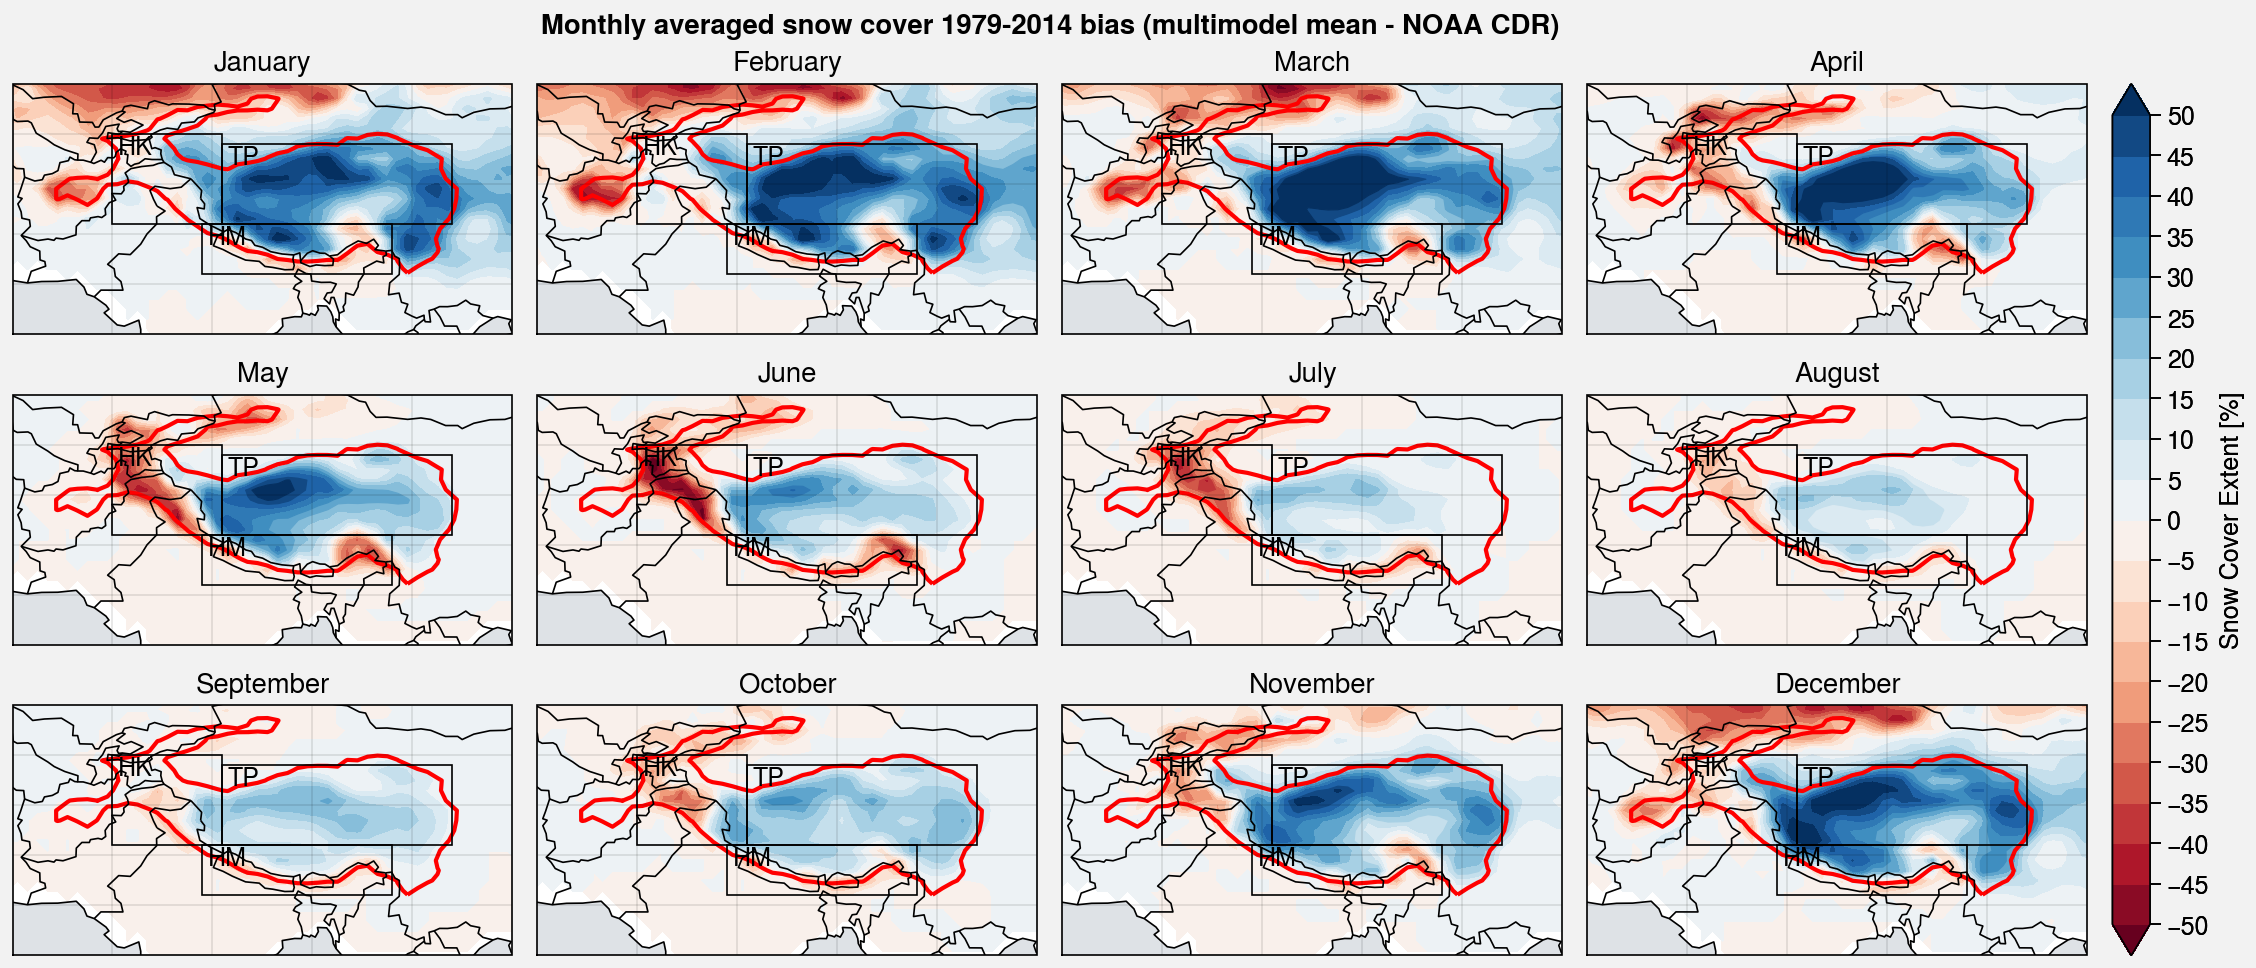

In [51]:
f, axs = plot.subplots(proj='cyl', ncols=4, nrows=3)

# tas, snc, pr
cmap = 'RdBu'
levels = plot.arange(-50,50,5)
extend = 'both'
norm = None

for i, month in enumerate(obs_monthly_clim.month.values):
    
    # Obs
    m = axs[i].contourf((multimodel_mean_monthly_clim.isel(month=i)-obs_monthly_clim.isel(month=i)), cmap=cmap, levels=levels, extend=extend, norm=norm)
    axs[i].format(title=calendar.month_name[i+1])


# Plot zones
for ax in axs:
    u.plot_zones(ax)
    ax.contour(elevation, levels=[2500], color='red')

# Format
axs.format(
    # Grids, labels and limits
    labels=False, lonlines=10, latlines=5, 
    latlim=(latlim.start, latlim.stop), lonlim=(lonlim.start, lonlim.stop),
    coast=True, ocean=True, oceancolor='gray3', borders=True,
    abc=False,
    suptitle='Monthly averaged snow cover 1979-2014 bias (multimodel mean - NOAA CDR)'
)

    
f.colorbar(m, label=label+' ['+units+']')

# Save
filename = 'snc_monthly_clim_bias_'+period.start+'-'+period.stop
# f.save('img/'+filename+'.jpg'); f.save('img/'+filename+'.png'); f.save('img/'+filename+'.pdf')